In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import allison
from allison.nn import Relu,Linear
from allison.nn import SGDMomentum
from allison.nn import Tensor,no_grad
from allison.nn import NeuralNetwork
from allison.nn import  MSELoss
from allison.preprocessing import MinMaxScaler
from allison.datasets import train_test_split
from allison.metrics import r2_score

In [233]:
device  = 'gpu' if allison.is_cuda_available() else 'cpu'
device = 'cpu'

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


# Datos

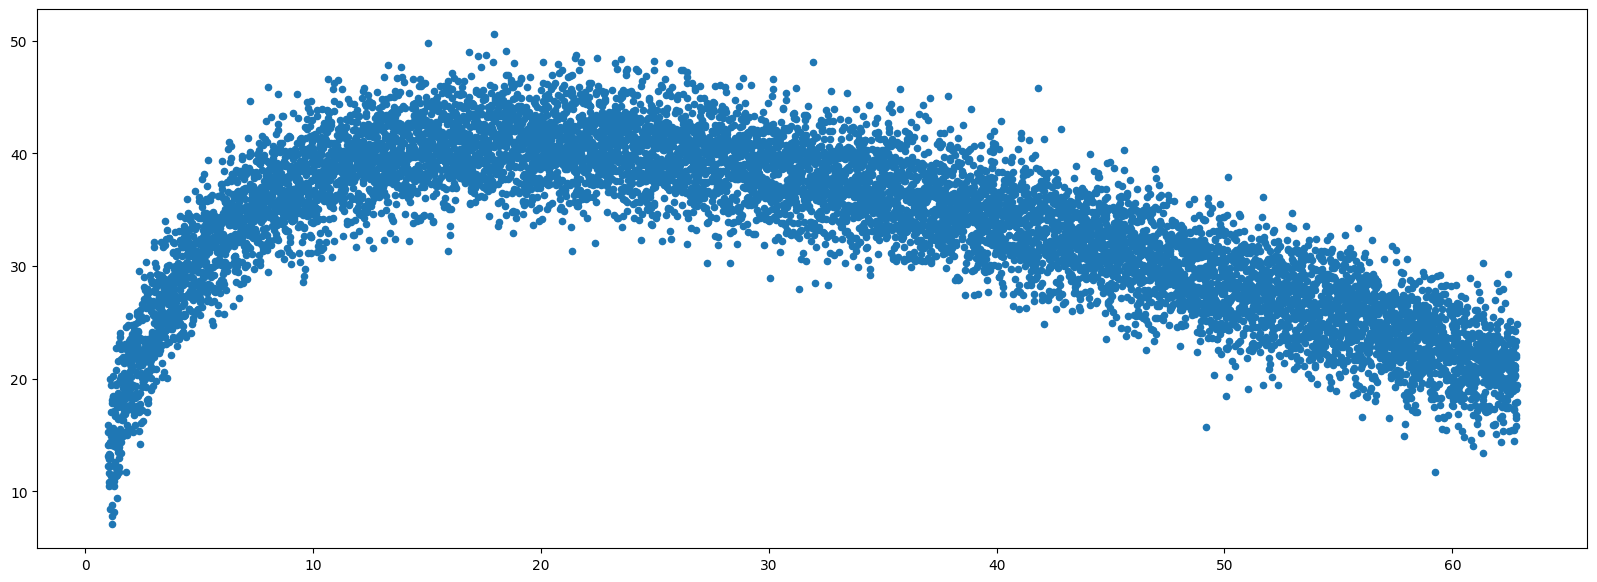

In [234]:
# Datos
points = 10000
x1 = np.linspace(1, 20*np.pi, points)
x2 = np.linspace(1, 20*np.pi, points)

# Definimos la salida
y = 20*np.log(x1+1) + -1*x2 + 3*np.random.randn(points)


data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data.head()

plt.figure(figsize=(20,7))
plt.scatter(data['x2'], data['y'], s=20)
plt.show()


# Preprocessing

In [235]:
independent_variables = ['x1', 'x2']
dependent_variable = ['y']

In [236]:
# Train test split and normalization
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

X_train = df_train[independent_variables]
Y_train = df_train[dependent_variable]

X_test = df_test[independent_variables]
Y_test = df_test[dependent_variable]

X_train

,x1,x2
6252,39.661141,39.661141
4684,29.964936,29.964936
1731,11.704164,11.704164
4742,30.323597,30.323597
4521,28.956976,28.956976
...,...,...
1638,11.129070,11.129070
5891,37.428788,37.428788
7427,46.927110,46.927110
608,4.759753,4.759753


In [237]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[0.62526253, 0.62526253],
       [0.46844684, 0.46844684],
       [0.17311731, 0.17311731],
       ...,
       [0.74277428, 0.74277428],
       [0.06080608, 0.06080608],
       [0.69076908, 0.69076908]], shape=(8000, 2))

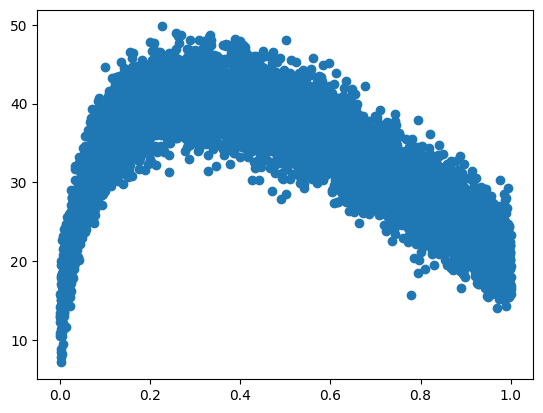

In [238]:
plt.Figure(figsize=(20,7))
plt.scatter(X_train[:,0], Y_train)
plt.show()

In [239]:
if device == 'gpu':

    X_train = Tensor(X_train).to(device)
    Y_train = Tensor(Y_train).to(device)

    X_test = Tensor(X_test).to(device)
    Y_test = Tensor(Y_test).to(device)
else:
    X_train = Tensor(X_train)
    Y_train = Tensor(Y_train)

    X_test = Tensor(X_test)
    Y_test = Tensor(Y_test)

print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}. device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")

X_train shape: (8000, 2), device: cpu
Y_train shape: (8000, 1). device: cpu
X_test shape: (2000, 2), device: cpu
Y_test shape: (2000, 1), device: cpu


In [240]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.relu = Relu()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

if device == 'gpu':
    net = Network().to(device)
else:
    net = Network()

In [241]:
net.parameters()

[Tensor(
 [[ 1.61599406  0.82602879  2.76252524 -1.55361243 -0.5060347  -0.94302519
    1.22936831 -0.22055036  0.1895162   0.63368553 -1.45478885 -0.62134896
    0.99726595 -0.5480879  -1.71364297 -0.90226289 -0.28626805  0.16676052
   -0.07081331 -0.61421784  0.93931344 -0.12906094  0.20940136 -0.56095598
    1.50894026 -0.39163111  0.07469287  1.03499944  0.28004226  0.2550897
   -1.97365551  0.680635    0.05558694  0.5415651   0.18321305 -0.55915756
    0.89430717  0.19812661 -1.28938649  1.30851716 -1.43047956  0.90092923
    1.48693177 -1.10629544 -0.12276179 -0.21594825 -0.17097116  1.83023836
   -1.09471887 -0.30656704  1.5033225  -0.32294883 -0.93577972  0.26301468
    0.80564054 -0.39284097  0.55436839 -1.37661509 -1.32102708 -0.44008628
    0.59001742  0.76149798 -1.18201605  0.7244207 ]
  [ 0.16650704 -0.87920469 -1.33418835  0.22982315  1.28956322  0.03552243
   -0.93492085 -1.86802229  1.52949085  1.04185061  0.30207685  1.47799397
    0.2239191  -0.53103695  0.55513225 -

In [242]:
criterion = MSELoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)

In [243]:
out = net(X_train)
out

Tensor(
[[0.64082439]
 [0.4801058 ]
 [0.17742595]
 ...
 [0.76126084]
 [0.06231945]
 [0.7079613 ]], shape=(8000, 1), device=cpu, requires_grad=True)

In [244]:
# %%
# Bucle de entrenamiento mejorado
for epoch in range(1000 + 1):
    Y_pred = net(X_train)
    loss = criterion(Y_train,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        r2_train = r2_score(Y_train, Y_pred)
        with no_grad():
            Y_pred = net(X_test)
            r2_test = r2_score(Y_test, Y_pred)
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.data:.4f} | R2_Train: {100*r2_train:5.2f} % | R2_Test: {100*r2_test:5.2f} %")
        if r2_test > 0.95:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

[cpu] Epoch     0 | Loss: 1139.0175 | R2_Train: -2120.54 % | R2_Test: -1938.37 %
[cpu] Epoch    10 | Loss: 333.1364 | R2_Train: -549.46 % | R2_Test: -251.46 %
[cpu] Epoch    20 | Loss: 145.1123 | R2_Train: -182.90 % | R2_Test: -33.25 %
[cpu] Epoch    30 | Loss: 51.1994 | R2_Train:  0.19 % | R2_Test: -27.20 %
[cpu] Epoch    40 | Loss: 41.9066 | R2_Train: 18.30 % | R2_Test: 31.06 %
[cpu] Epoch    50 | Loss: 34.2962 | R2_Train: 33.14 % | R2_Test: 32.41 %
[cpu] Epoch    60 | Loss: 31.6776 | R2_Train: 38.24 % | R2_Test: 41.66 %
[cpu] Epoch    70 | Loss: 29.3568 | R2_Train: 42.77 % | R2_Test: 44.83 %
[cpu] Epoch    80 | Loss: 26.9226 | R2_Train: 47.51 % | R2_Test: 49.52 %
[cpu] Epoch    90 | Loss: 24.9235 | R2_Train: 51.41 % | R2_Test: 53.16 %
[cpu] Epoch   100 | Loss: 23.1712 | R2_Train: 54.83 % | R2_Test: 56.62 %
[cpu] Epoch   110 | Loss: 21.5731 | R2_Train: 57.94 % | R2_Test: 59.52 %
[cpu] Epoch   120 | Loss: 20.0307 | R2_Train: 60.95 % | R2_Test: 62.36 %
[cpu] Epoch   130 | Loss: 18.5536

In [245]:
r2_score(Y_test, Y_pred)

np.float64(0.8196665097771683)

Text(0.5, 1.0, 'Polinomic Regression on Test Data(Accuracy:81.97%)')

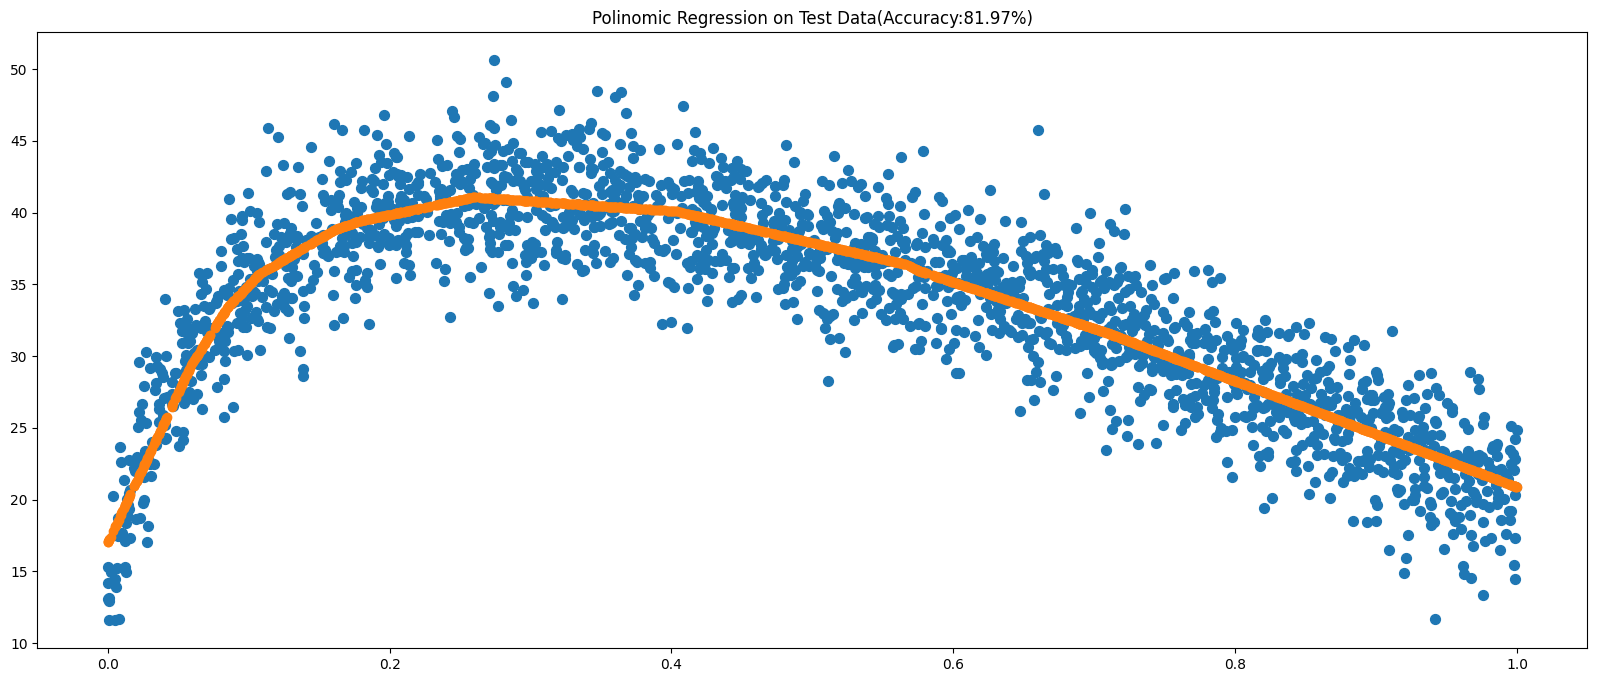

In [246]:
# %%
# Visualización final

with no_grad():
    y_pred = net(X_test)

r2 = r2_score(Y_test, y_pred)

plt.figure(figsize=(20,8))
plt.scatter(X_test.to('cpu')[:,0].data,Y_test.to('cpu').data,s=50)
plt.scatter(X_test.to('cpu')[:,0].data,y_pred.to('cpu').data)
plt.title(f'Polinomic Regression on Test Data(Accuracy:{r2*100:.2f}%)')

# Save and Load Model

In [247]:
import joblib

In [248]:
joblib.dump(net.weights(), 'regression_weights.joblib')

['regression_weights.joblib']

# CPU

In [249]:
net2 = Network()
net2.load_weights(joblib.load('regression_weights.joblib'))

if X_test.device == 'cpu':
    out = net2(X_test)
if X_test.device == 'gpu':
    out = net2(X_test.to('cpu'))

out

Tensor(
[[25.34067415]
 [31.04175719]
 [33.83973118]
 ...
 [37.01058127]
 [33.5032496 ]
 [30.95676898]], shape=(2000, 1), device=cpu, requires_grad=True)

# GPU

In [250]:
net2 = Network()
net2.load_weights(joblib.load('regression_weights.joblib'))
net2.to('gpu')

if X_test.device == 'cpu':
    out = net2(X_test.to('gpu'))
if X_test.device == 'gpu':
    out = net2(X_test)

out

Tensor(
[[25.34067415]
 [31.04175719]
 [33.83973118]
 ...
 [37.01058127]
 [33.5032496 ]
 [30.95676898]], shape=(2000, 1), device=gpu, requires_grad=True)